In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, LeakyReLU

def buildLSTM(units, step_size, nb_features, output_size):
    net = LSTM(
        units=units,
        activation='tanh',
        input_shape=(step_size, nb_features),
        return_sequences=False)
    
    model = Sequential()
    model.add(net)
    model.add(Dropout(0.8))
    model.add(Dense(output_size))
    model.add(LeakyReLU())
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GRU

def buildGRU(units, step_size, nb_features, output_size):
    net = GRU(
        units=units,
        input_shape=(step_size,nb_features),
        return_sequences=False
    )
    
    model = Sequential()
    model.add(net)
    model.add(Activation('tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(output_size))
    model.add(Activation('relu'))
    model.compile(loss='mse', optimizer='adam')
    
    return model
    

In [4]:
import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
        
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

In [5]:
from sklearn.preprocessing import MinMaxScaler

def cleanData(columns, datas):
    scaler = MinMaxScaler()
    for c in columns:
        datas[c] = scaler.fit_transform(datas[c].values.reshape(-1,1))
        
    return datas

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 6001 samples, validate on 1501 samples
Epoch 1/30
6001/6001 [==============================] - 202s 34ms/step - loss: 0.0032 - val_loss: 1.3086e-04
Epoch 2/30
6001/6001 [==============================] - 181s 30ms/step - loss: 5.4661e-04 - val_loss: 3.6912e-04
Epoch 3/30
6001/6001 [==============================] - 174s 29ms/step - loss: 3.8768e-04 - val_loss: 1.9970e-05
Epoch 4/30
6001/6001 [==============================] - 180s 30ms/step - loss: 3.1012e-04 - val_loss: 1.7953e-04
Epoch 5/30
6001/6001 [==============================] - 178s 30ms/step - loss: 2.7999e-04 - val_loss: 1.8577e-05
Epoch 6/30
6001/6001 [==============================] - 193s 32ms/step - loss: 2.4648e-04 - val_loss: 1.7125e-04
Epoch 7/30
6001/6001 [==============================] - 177s 29ms/step - loss: 2.4560e-04 - val_loss: 3.2512e-04
Epoch 8/30
6001/6001 [==============================] - 175s 29ms/step - loss: 2.2728e-04 - val_loss: 3.8361e-04
Epoch 9/30
6001/6001 [==============================

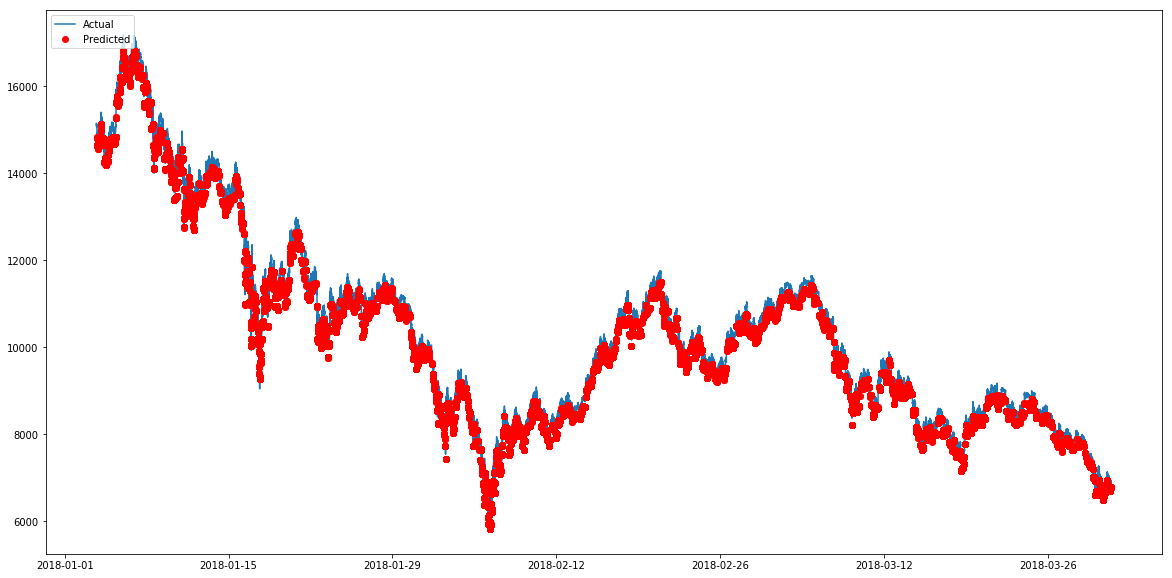

In [9]:
import numpy as np
import pandas as pd
from keras.callbacks import CSVLogger
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt

config = tf.ConfigProto()
set_session(tf.Session(config=config))

# number of samples before t = 0
step_size = 256

# number predictions after t = 0
output_size=16

units= 200
batch_size = 8
epochs = 30
input_file_name='proc_data.csv'
output_file_name='bitcoin2014to2018_close_LSTM_1_tanh_leaky_'

columns = ['price','vol','sentiment']
nb_features = len(columns)

datas = pd.read_csv(input_file_name)

cleaned_datas = cleanData(columns, datas.copy())

# build data set using time series
ps = PastSampler(step_size, output_size, sliding_window=False)

inputs, labels = ps.transform(np.array(cleaned_datas)[:,np.newaxis,:])
o_i, o_l = ps.transform(np.array(datas)[:,np.newaxis,:])
time_input, time_output = ps.transform(np.array(datas['time'])[:,np.newaxis,np.newaxis])

inputs = inputs[:,:,1:]
labels = labels[:,:,1]

#split training validation
training_size = int(0.8* inputs.shape[0])

training_datas = inputs[:training_size,:,:]
training_labels = labels[:training_size,:]

validation_datas = inputs[training_size:,:,:]
validation_labels = labels[training_size:,:]

val_o_i = o_i[training_size:,:,:]
val_o_l = o_l[training_size:,:,:]

validation_input_times = time_input[training_size:,:]
validation_output_times = time_output[training_size:,:]

ground_true_times = np.append(validation_input_times, validation_output_times, axis=1)
ground_true = np.append(val_o_i, val_o_l, axis=1)

# model = buildLSTM(units, step_size, nb_features, output_size)
model = buildGRU(units, step_size, nb_features, output_size)

model.fit(
    training_datas,
    training_labels,
    batch_size=batch_size,
    validation_data=(validation_datas,validation_labels),
    epochs = epochs,
    callbacks=[CSVLogger(output_file_name+'.csv', append=True)]
)

predictions = model.predict(validation_datas)
predictions_invert = []

scaler = MinMaxScaler()
scaler.fit(np.array(datas['price']).reshape(-1,1))
predictions_invert = scaler.inverse_transform(predictions)

ground_true = ground_true[:,:,1].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension

validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true

prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = np.array(predictions_invert).reshape(-1)

# prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2017 )&(prediction_df["times"].dt.month > 7 ),: ]
# ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2017 )&(ground_true_df["times"].dt.month > 7 ),:]

plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.show()